# Assignment 1

## Question 3 (Linear Regression)

This assignment will have you working and experimenting with linear regression. The general multiple linear regression model, given $p$ predictors, is defined as: $$Y=\beta_0+\beta_1X_1+\beta_2X_2+...+\beta_pX_p+\epsilon,$$ where $Y$ is the response variable, $X_j$ is the $j$<sup>th</sup> predictor and $\beta_j$ quantifies the association between the response and the variable. A good way to think about $\beta_j$ is as the average effect on $Y$ of a one unit increase in $X_j$, holding all other predictors fixed. The $\epsilon$ term is the error term, which is independent of $X$ and has mean zero (the expected value of $Y$ when all variables are set to zero).

Work with Numpy only and do not use library functions that directly perform model fitting like `np.polyfit`. However, you may use library functions to compare your results while experimenting. This assignment becomes much easier to complete if accompanied by reading the third chapter in An Introduction to Statistical Learning. The text is freely available for download on the internet at [statlearning.com](statlearning.com)

Reference: James, G., Witten, D., Hastie, T., Tibshirani, R., Taylor, J. (2023). Linear Regression. In: An Introduction to Statistical Learning. Springer Texts in Statistics. Springer, Cham. https://doi.org/10.1007/978-3-031-38747-0_3

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(42)
# other imports if necessary

/tmp/ipykernel_587185/413043453.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Part 1: Simple Regression

In this part, the function `gen_data()` samples hundred data points from a random 25 degree single-variable polynomial. This data is stored in the `predictor` and `response` variables. Your task is to experiment with linear regression on this dataset. Specifically:

1. Fit a line to the curve $(y=\beta_1x+\beta_0)$
2. Fit a polynomial to the curve $(y=\sum_{0}^{k}\beta_kx^k)$ and choose $k$ that satisfactorily minimizes error.
    - Note that the original polynomial is a 25 degree polynomial and we might not need exactly that many.
    - Check how well the coefficients match when we try to fit a 25 degree polynomial to the data. Get the coefficients from the `gen_data()` function.

Report error metrics for all experiments in tabular form (or any other way that helps us compare and choose between the different methods)



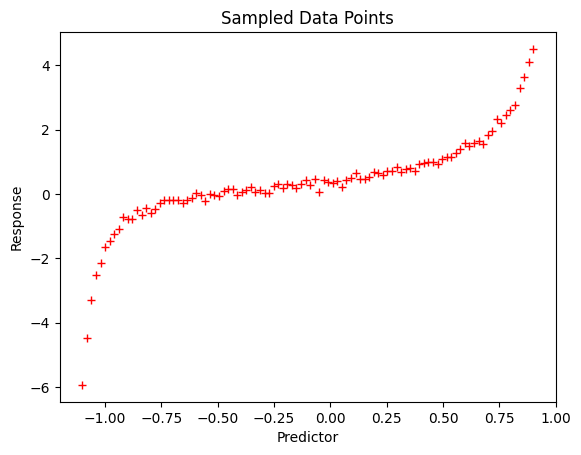

In [2]:
def gen_data():
    coeff = np.random.rand(26)
    x = np.linspace(-1.1, 0.9, 100)
    y = np.zeros_like(x)
    for i, c in enumerate(coeff):
        y += c * x**i
    y += np.random.randn(100) * 0.1

    return x, y, coeff

predictor, response, coeff = gen_data()

plt.plot(predictor, response, 'r+')
plt.xlabel('Predictor')
plt.ylabel('Response')
plt.title('Sampled Data Points')
plt.show()

In [3]:
def shuffle_data(x,y):
    index_array = np.arange(len(x))
    np.random.shuffle(index_array)
    x_shuffled = x[index_array]
    y_shuffled = y[index_array]
    return x_shuffled, y_shuffled

def mse(y_pred, y_true):
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)
    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    return np.mean(np.square(y_pred-y_true))
    

x,y = shuffle_data(predictor, response)
test_split = 0.2
train_split = 1 - test_split
n_train = int(np.floor(x.shape[0]*train_split))
x_train, y_train = x[:n_train], y[:n_train]
x_test, y_test = x[n_train:], y[n_train:]

In [4]:
# your code here
class LinearRegression():
    def __init__(self, learning_rate = 0.001, n_iterations = 10, alpha = 0.01, 
                 regularisation = None , gradient_clipping = False, gradient_threshold = 10):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularisation = regularisation
        self.alpha = alpha
        self.gradients = []
        self.loss = []
        self.gradient_clipping = gradient_clipping
        self.gradient_threshold = gradient_threshold
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        if y.ndim == 1:
            y = y.reshape(-1, 1)
            
        x = np.concatenate((np.ones((x.shape[0], 1)),x), axis =1)
        self.weights = np.zeros((x.shape[-1],1))
        for iter in range(self.n_iterations):
            preds = np.dot(x,self.weights)
            error = preds - y
            if self.regularisation == None:
                gradients = np.dot(x.T,error)
                loss = np.mean(error ** 2)
            elif self.regularisation == 'l1':
                gradients = np.dot(x.T,error) + self.alpha * np.sign(self.weights)
                loss = np.mean(error ** 2) + self.alpha * np.sum(np.abs(self.weights))
            elif self.regularisation == 'l2':
                gradients = np.dot(x.T,error) + 2 * self.alpha * self.weights
                loss = np.mean(error ** 2) + self.alpha * np.sum(self.weights ** 2)

            if self.gradient_clipping == True:
                gradient_norm = np.linalg.norm(gradients)
                if gradient_norm > self.gradient_threshold:
                    gradients = (gradients / gradient_norm) * self.gradient_threshold
                else:
                    gradients = gradients

            self.weights -= self.learning_rate*gradients
            self.loss.append(loss)
            self.gradients.append(gradients)
            # print(f"Iteration : {iter}, Loss : {loss}")#, end='\r')
            
    def predict(self, x_test):
        if x_test.ndim == 1:
            x_test = x_test.reshape(-1, 1)
        x_test = np.concatenate((np.ones((x_test.shape[0], 1)),x_test), axis =1)
        return np.dot(x_test, self.weights)

In [5]:
model = LinearRegression(regularisation= None, n_iterations = 50)
model.fit(x_train, y_train)
preds = model.predict(x_test)
error = np.mean(np.square(preds-y_test))
print("Error with Linear regression : ",error)

Error with Linear regression :  3.103543612987014


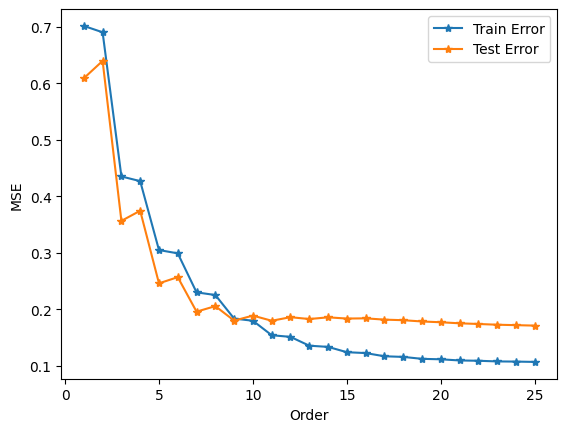

In [6]:
# Polynomial regression
errors = []
train_errors = []
for order in range(1,26):
    x_train_ploy = np.vander(x_train, order + 1, increasing=True)[:,1:]
    x_test_poly = np.vander(x_test, order + 1, increasing=True)[:,1:]
    model_poly = LinearRegression(learning_rate = 0.001,regularisation= None, n_iterations = 50)
    model_poly.fit(x_train_ploy, y_train)
    preds_poly = model_poly.predict(x_test_poly)
    error = mse(preds_poly, y_test)
    errors.append(error)
    train_preds = model_poly.predict(x_train_ploy)
    error_t = mse(train_preds, y_train)
    train_errors.append(error_t)
    
plt.plot(range(1,26), train_errors, '*-', label='Train Error')
plt.plot(range(1,26), errors, '*-',label='Test Error')
plt.xlabel('Order')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [7]:
print("Model Weights:")
print(model_poly.weights.reshape(-1,26)[0])
print("Actual coefficients:")
print(coeff)
mse_of_weights = np.mean(np.square(coeff.reshape(-1,1)-model_poly.weights))
print("\nMSE of model weights and actual weights :",mse_of_weights)

Model Weights:
[ 0.52113258  0.8385675   0.30317139  0.5201755   0.18362656  0.36350981
  0.11294723  0.27016054  0.06801502  0.20898179  0.03822636  0.16645185
  0.018028    0.13558367  0.0042476   0.11234775 -0.00502661  0.09423341
 -0.01098123  0.07957689 -0.01435811  0.06721213 -0.01560998  0.0562741
 -0.01498969  0.04608024]
Actual coefficients:
[0.37454012 0.95071431 0.73199394 0.59865848 0.15601864 0.15599452
 0.05808361 0.86617615 0.60111501 0.70807258 0.02058449 0.96990985
 0.83244264 0.21233911 0.18182497 0.18340451 0.30424224 0.52475643
 0.43194502 0.29122914 0.61185289 0.13949386 0.29214465 0.36636184
 0.45606998 0.78517596]

MSE of model weights and actual weights : 0.1688246981117008


### Observations
1. From the plot above which shows train and test error of model with different order, it is observed that at order 9 both train and test errors are least and then after test error started fluctuating and constant.
2. From the pattern order 9 is least order required to achieve best performance.
3. So, it is observed that even polynomial generated with degree 25, needs degree 9 to better fit the polynomial.

#### Part 1.1 Regularization

In this section, you will be required to perform the converse of the previous section. After generating data from a lower degree polynomial, you will try to fit a higher degree polynomial to it. This will result in overfitting. You will then use regularization to reduce the overfitting. Try both L1 and L2 regularization and compare the results.

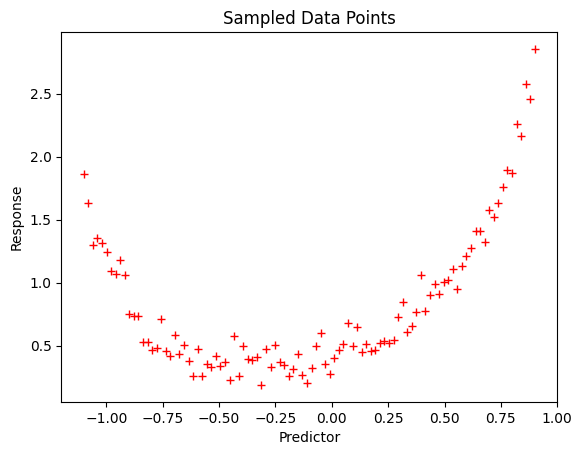

In [8]:
def gen_data_low():
    coeff = np.random.rand(np.random.choice([3, 5, 7]))
    x = np.linspace(-1.1, 0.9, 100)
    y = np.zeros_like(x)
    for i, c in enumerate(coeff):
        y += c * x**i
    y += np.random.randn(100) * 0.1

    return x, y, coeff

predictor_low, response_low, coeff = gen_data_low()

plt.plot(predictor_low, response_low, 'r+')
plt.xlabel('Predictor')
plt.ylabel('Response')
plt.title('Sampled Data Points')
plt.show()

In [9]:
# your code here
x,y = shuffle_data(predictor_low, response_low)
test_split = 0.2
train_split = 1 - test_split
n_train = int(np.floor(x.shape[0]*train_split))
x_train, y_train = x[:n_train], y[:n_train]
x_test, y_test = x[n_train:], y[n_train:]
print("Order of training data : ",len(coeff))

Order of training data :  7


In [10]:
order = len(coeff) + 10 #taking order 10 more than training data for training 
x_train_poly = np.vander(x_train, order + 1, increasing=True)[:,1:]
x_test_poly = np.vander(x_test, order + 1, increasing=True)[:,1:]

# No Regularisation
model_noreg = LinearRegression(learning_rate = 0.001,regularisation= None, n_iterations = 50)
model_noreg.fit(x_train_poly, y_train)
y_train_noreg = model_noreg.predict(x_train_poly)
y_test_noreg = model_noreg.predict(x_test_poly)

# L1 Regularisation
model_l1 = LinearRegression(learning_rate = 0.001,regularisation= "l1", alpha = 1, n_iterations = 50)
model_l1.fit(x_train_poly, y_train)
y_train_l1 = model_l1.predict(x_train_poly)
y_test_l1 = model_l1.predict(x_test_poly)

#L2 Regularisation
model_l2 = LinearRegression(learning_rate = 0.001,regularisation= "l2", alpha = 1, n_iterations = 50)
model_l2.fit(x_train_poly, y_train)
y_train_l2 = model_l2.predict(x_train_poly)
y_test_l2 = model_l2.predict(x_test_poly)
print("Train and test errors of different methods with and without regularisation with order degree+10 ")
print(f"No regularisation - Train:{mse(y_train_noreg, y_train)} ; Test:{mse(y_test_noreg, y_test)}")
print(f"L1 regularisation - Train:{mse(y_train_l1, y_train)} ; Test:{mse(y_test_l1, y_test)}")
print(f"L2 regularisation - Train:{mse(y_train_l2, y_train)} ; Test:{mse(y_test_l2, y_test)}")

Train and test errors of different methods with and without regularisation with order degree+10 
No regularisation - Train:0.050879759748495436 ; Test:0.03956190588675119
L1 regularisation - Train:0.06708897131614917 ; Test:0.049326322130659545
L2 regularisation - Train:0.05577451004199117 ; Test:0.04349412692759476


# Observations
1. Not improvement is observed with regularisation methods, model without regulariation giveing best performance
2. Hypothesizing that since the test data is also come from the same polynomial with little noise, if a model overfit to the training data it is performing well on test data also.

### Part 2: Credit Data

In this part, we work with the credit.csv file that predicts `Balance` after looking at predictors like `Income`, `Age`, `Limit`, etc. Your task is to understand the relationship between the predictors and response using linear regression techniques. Specifically:

1. Perform multiple linear regression on the dataset. $(Y=\sum\beta_iX_i+\epsilon)$
2. Test whether all the variables are needed to predict `Balance` or if any of them can be discarded.
3. Test for [interaction effects](https://en.wikipedia.org/wiki/Interaction_(statistics)#In_regression) between `Rating` and `Age`.

As before, perform the above experiments by obtaining and reporting error metrics for all experiments.

In [11]:
credit = pd.read_csv('credit.csv')
credit.head()

,Income,Limit,Rating,Cards,Age,Education,Balance
0,14.891,3606,283,2,34,11,333
1,106.025,6645,483,3,82,15,903
2,104.593,7075,514,4,71,11,580
3,148.924,9504,681,3,36,11,964
4,55.882,4897,357,2,68,16,331


In [12]:
x, y = credit.iloc[:,:-1].to_numpy(), credit['Balance'].to_numpy()
x, y = shuffle_data(x, y)
test_split = 0.2
train_split = 1 - test_split
n_train = int(np.floor(x.shape[0]*train_split))
x_train, y_train = x[:n_train], y[:n_train]
x_test, y_test = x[n_train:], y[n_train:]

In [13]:
model = LinearRegression(n_iterations = 50, learning_rate=0.001, gradient_clipping=True, gradient_threshold = 10, regularisation=None, alpha=1)
model.fit(x_train, y_train)
preds = model.predict(x_test)
print(f"MSE of test set: {mse(preds, y_test)}")

MSE of test set: 75687.34008443374


In [14]:
model = LinearRegression(n_iterations = 50, learning_rate=0.001, gradient_clipping=True, gradient_threshold = 10, regularisation='l1', alpha=1)
model.fit(x_train, y_train)
preds = model.predict(x_test)
print(f"MSE of test set: {mse(preds, y_test)}")
print("Model weights:",model.weights)

MSE of test set: 75687.34014824723
Model weights: [[-0.00025124]
 [-0.01146037]
 [ 0.11975624]
 [-0.00065797]
 [-0.00049324]
 [-0.01590914]
 [-0.00319653]]


# Observation
1. It is been observed that not much performance improvement from L1 regularisation.
2. L1 regularisation is performed to make weights sparse to check if all the features are needed.
3. From the weights it is observed that the features **cards**, **Education** and **Rating** features are not contibuting much since their weights are very less than others. Hence these features can be neglected.

In [15]:
from sklearn.linear_model import LinearRegression as sk_LinearRegression
model = sk_LinearRegression()
model.fit(x_train, y_train)
preds = model.predict(x_test)
print(f"MSE of test set: {mse(preds, y_test)}")

MSE of test set: 22725.464940566882


## Some observations
1. Since the output variable is high (in 100s), the code written uses batch gradient descent. Gradient exploding issue happened and gradient clipping is used to avoid this issue with different thresholds and found out 10 is the best suited based on teste set performance.
### The same dataset is used to train model using library function to compare the performence
1. It is observed that the MSE using library function is also high, but library function is low compared to my model. Since library function used closed form it may be finding optiomal solution whereas as I used gradient descent approach with gradient clipping, so hyper parameter tuning may be needed further to get best performance.

### Part 3: Shark Attacks

This is a fun dataset that aims to predict the number of shark attacks (`SharkAttacks`) using variables like `Year`, `Month`, `Temperature`, and `IceCreamSales`. This dataset has been used in popular media to show how correlation does not imply causation. Test whether predictions made with ice cream sales data are any better/worse than predictions made by neglecting ice cream sales data.

This sort of analysis reminds us that it is important to look at the data before using it for learning representations.

In [16]:
sharks = pd.read_csv('shark_attacks.csv')
sharks.head()

,Year,Month,SharkAttacks,Temperature,IceCreamSales
0,2008,1,25,11.9,76
1,2008,2,28,15.2,79
2,2008,3,32,17.2,91
3,2008,4,35,18.5,95
4,2008,5,38,19.4,103


In [17]:
# your code here
x, y = sharks[['IceCreamSales']].to_numpy(), sharks['SharkAttacks'].to_numpy()
x_shuffled, y_shuffled = shuffle_data(x, y)
test_split = 0.2
train_split = 1 - test_split
n_train = int(np.floor(x.shape[0]*train_split))
x_train, y_train = x_shuffled[:n_train], y_shuffled[:n_train]
x_test, y_test = x_shuffled[n_train:], y_shuffled[n_train:]
model = LinearRegression(n_iterations = 50, learning_rate=0.001, gradient_clipping=True, gradient_threshold=10)
model.fit(x_train, y_train)
preds = model.predict(x_test)
print(f"MSE of test set: {mse(preds, y_test)}")

MSE of test set: 40.47202433710066


In [18]:
# your code here
x, y = sharks[['Year','Month','Temperature']].to_numpy(), sharks['SharkAttacks'].to_numpy()
x_shuffled, y_shuffled = shuffle_data(x, y)
test_split = 0.2
train_split = 1 - test_split
n_train = int(np.floor(x.shape[0]*train_split))
x_train, y_train = x_shuffled[:n_train], y_shuffled[:n_train]
x_test, y_test = x_shuffled[n_train:], y_shuffled[n_train:]
model = LinearRegression(n_iterations = 50, learning_rate=0.001, gradient_clipping=True, gradient_threshold=10)
model.fit(x_train, y_train)
preds = model.predict(x_test)
print(f"MSE of test set: {mse(preds, y_test)}")

MSE of test set: 121.06541427834621


# Observations
1. Predictions made with only ice cream sales data are better than predictions made with all other features by neglecting ice cream sales.
